In [1]:
#读入数据
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

trainData = pd.read_csv("nlp-getting-started-data/train.csv")

trainKeyword=trainData.values[:,1]
trainLocation=trainData.values[:,2]
trainText=trainData.values[:,3]
trainTarget=trainData.values[:,4]

print(trainData)

c:\Users\24508\Anaconda3\envs\jqxx\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

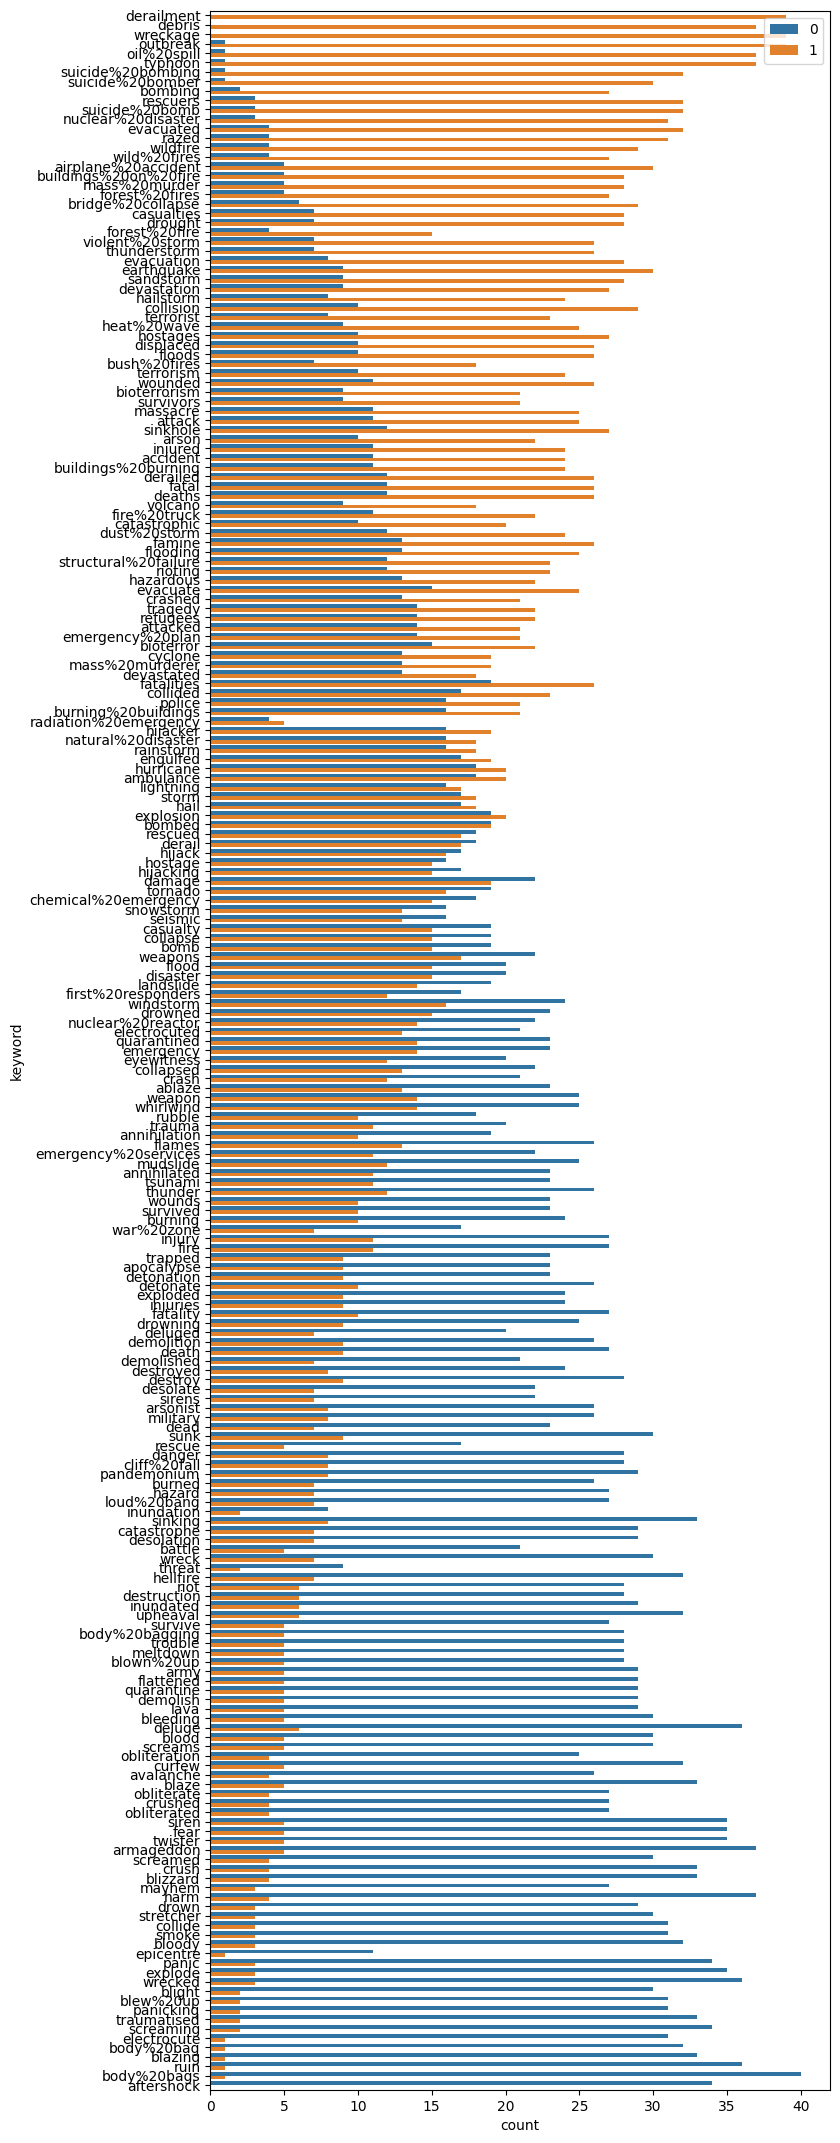

In [15]:
import seaborn as sns #一个Matplotlib高级数据可视化库，画统计图表

trainData['targetMean']=trainData.groupby('keyword')['target'].transform('mean')
fig = plt.figure(figsize=(8,27))
sns.countplot(y=trainData.sort_values(by='targetMean',ascending=False)['keyword'], hue=trainData.sort_values(by='targetMean',ascending=False)['target']) #按照targetMean排序，默认升序，ascending=False改为降序排序

plt.legend(loc=1)

plt.show()

trainData.drop(columns=['targetMean'], inplace=True) #inplace=True的时候在原来的数据上发生改变，默认为inplace=False不改变原数据